In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f"Examples:\n    Total: {total}\n    Positive: {pos}, {100 * (pos/total)}")

Examples:
    Total: 284807
    Positive: 492, 0.1727485630620034


## Conversion to Log Space

In [8]:
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps = 0.001 # Amount column covers huge range. Convert to log-space
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [10]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

## Normalize, Scaler

In [11]:
scaler = StandardScaler()
train_feature = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [12]:
print(f'Training labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print('Test labels shape: {test_labels.shape}')

print(f'Training features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Test features shape: {test_features.shape}')

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: {test_labels.shape}
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


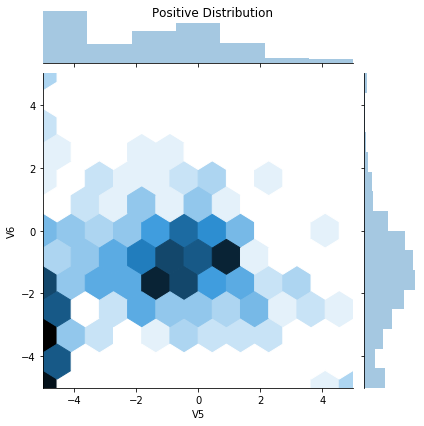

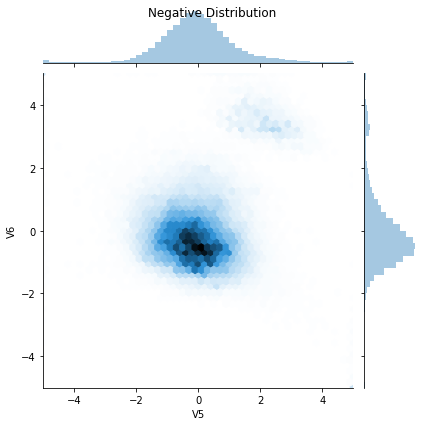

In [15]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
plt.suptitle("Positive Distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
_ = plt.suptitle("Negative Distribution")

In [38]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if(output_bias is not None):
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [39]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [40]:
model = make_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.predict(train_feature[:10])

array([[0.29454386],
       [0.36461765],
       [0.43566313],
       [0.9861801 ],
       [0.44411474],
       [0.11276907],
       [0.45771173],
       [0.3848323 ],
       [0.17720227],
       [0.18142466]], dtype=float32)

In [42]:
results = model.evaluate(
    train_feature, 
    train_labels, 
    batch_size=BATCH_SIZE, 
    verbose=0
)
print(f"Loss: {results[0]}")

Loss: 0.504362368524034


## Bias

In [43]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [44]:
model = make_model(output_bias=initial_bias)
model.predict(train_feature[:10])

array([[0.00391631],
       [0.00187401],
       [0.00319466],
       [0.00246738],
       [0.00505925],
       [0.00109741],
       [0.00505025],
       [0.00201681],
       [0.0024947 ],
       [0.00320252]], dtype=float32)

In [46]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print(f"Loss: {results[0]}")

Loss: 0.012798017278963472


In [47]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

## Bias Fix Confirmation

In [49]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [50]:
initial_weights

'/var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmp_uqe2qhl/initial_weights'

In [51]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [52]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()

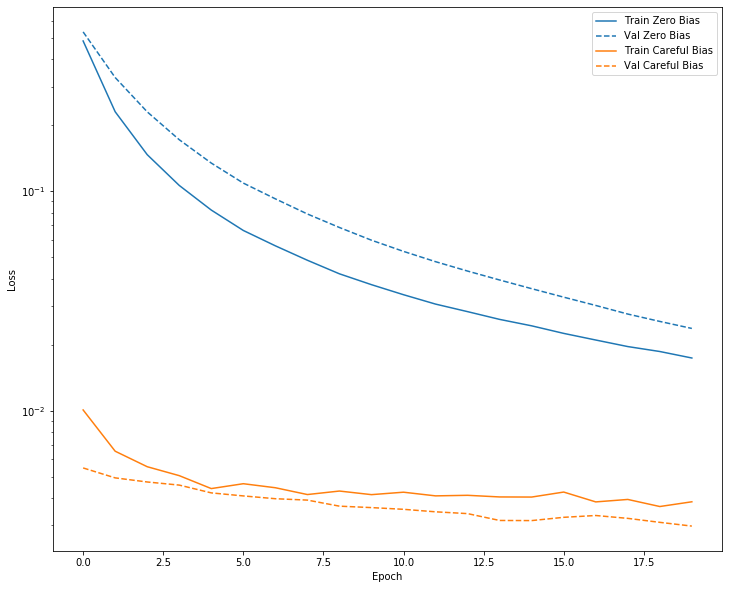

In [53]:
plot_loss(zero_bias_history,"Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Train the Model

In [54]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 3s 14us/sample - loss: 0.0099 - tp: 73.0000 - fp: 79.0000 - tn: 181885.0000 - fn: 239.0000 - accuracy: 0.9983 - precision: 0.4803 - recall: 0.2340 - auc: 0.8203 - val_loss: 0.0055 - val_tp: 43.0000 - val_fp: 13.0000 - val_tn: 45489.0000 - val_fn: 24.0000 - val_accuracy: 0.9992 - val_precision: 0.7679 - val_recall: 0.6418 - val_auc: 0.9489
Epoch 2/100
182276/182276 [==============================] - 0s 3us/sample - loss: 0.0065 - tp: 140.0000 - fp: 38.0000 - tn: 181926.0000 - fn: 172.0000 - accuracy: 0.9988 - precision: 0.7865 - recall: 0.4487 - auc: 0.9053 - val_loss: 0.0050 - val_tp: 48.0000 - val_fp: 14.0000 - val_tn: 45488.0000 - val_fn: 19.0000 - val_accuracy: 0.9993 - val_precision: 0.7742 - val_recall: 0.7164 - val_auc: 0.9233
Epoch 3/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.0055 - tp: 164.0000 - fp: 30.0000 - tn: 181934.0000 - fn: 14

In [57]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, 
            history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, 
            history.history['val_' + metric], color=colors[0], linestyle="--", label="Val")
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if(metric == 'loss'):
            plt.ylim([0, plt.ylim()[1]])
        elif(metric == 'auc'):
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
            
        plt.legend()

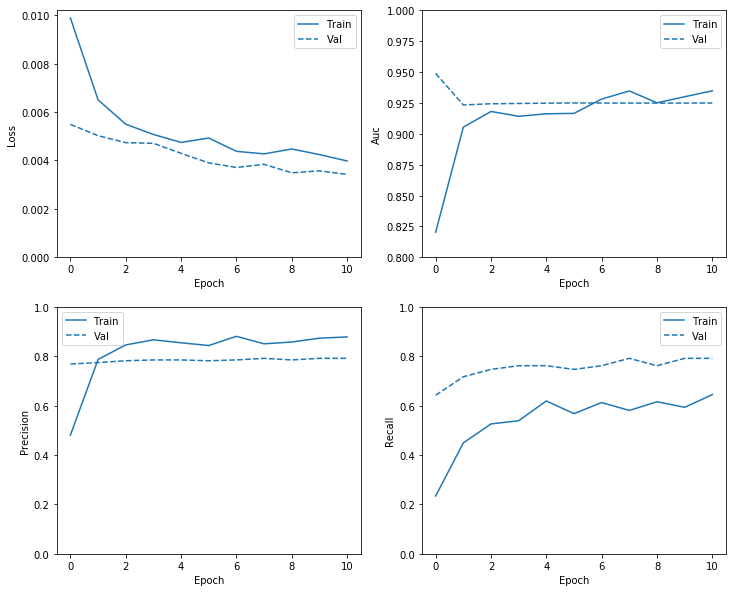

In [58]:
plot_metrics(baseline_history)

## Evaluation Metrics: Confusion Matrix

In [59]:
train_predictions_baseline = model.predict(
    train_features, batch_size=BATCH_SIZE
)
test_predictions_baseline = model.predict(
    test_features, batch_size=BATCH_SIZE
)

In [62]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix @{p}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    print(f"Legitimate Transactions Detected (True Negatives): {cm[0][0]}")
    print(f"Legitimate Transactions Incorrectly Detected (False Positives): {cm[0][1]}")
    print(f"Fraudulent Transactions Missed (False Negatives): {cm[1][0]}")
    print(f"Fraudulent Transactions Detected (True Positives): {cm[1][1]}")
    print(f"Total Fraudulent Transactions: {np.sum(cm[1])}")

loss :  0.005912997071204815
tp :  62.0
fp :  9.0
tn :  56840.0
fn :  51.0
accuracy :  0.99894667
precision :  0.87323946
recall :  0.54867256
auc :  0.94575554

Legitimate Transactions Detected (True Negatives): 56840
Legitimate Transactions Incorrectly Detected (False Positives): 9
Fraudulent Transactions Missed (False Negatives): 51
Fraudulent Transactions Detected (True Positives): 62
Total Fraudulent Transactions: 113


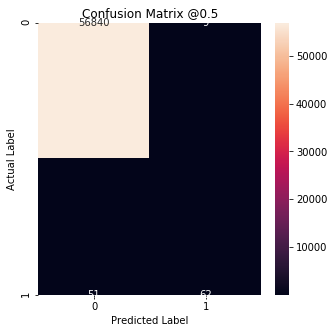

In [63]:
baseline_results = model.evaluate(
    test_features,
    test_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ": ", value)
print()
plot_cm(test_labels, test_predictions_baseline)

## Plot the ROC

In [64]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

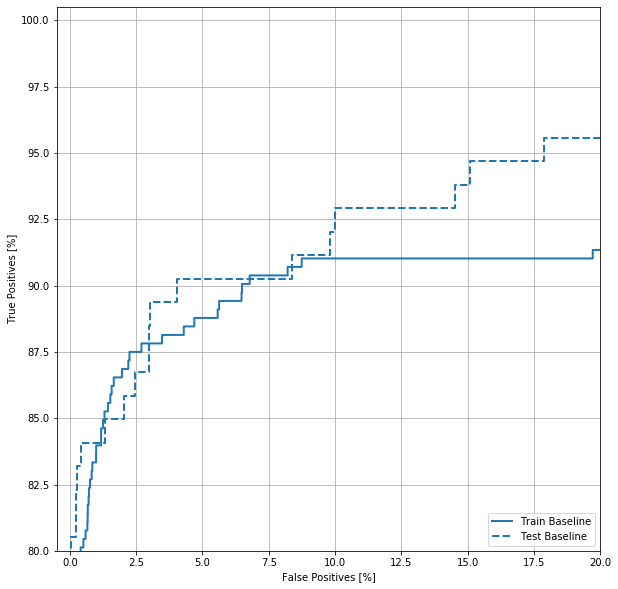

In [66]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Class Weights

In [67]:
weight_for_0 = (1 / neg) * (total) / 2.0
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {
    0: weight_for_0,
    1: weight_for_1
}

print(f"Weight for Class 0: {weight_for_0}")
print(f"Weight for Class 1: {weight_for_1}")

Weight for Class 0: 0.5008652375006595
Weight for Class 1: 289.43800813008136


In [70]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 3s 14us/sample - loss: 1.5203 - tp: 108.0000 - fp: 388.0000 - tn: 181576.0000 - fn: 204.0000 - accuracy: 0.9968 - precision: 0.2177 - recall: 0.3462 - auc: 0.8223 - val_loss: 0.3872 - val_tp: 50.0000 - val_fp: 37.0000 - val_tn: 45465.0000 - val_fn: 17.0000 - val_accuracy: 0.9988 - val_precision: 0.5747 - val_recall: 0.7463 - val_auc: 0.9656
Epoch 2/100
182276/182276 [==============================] - 0s 3us/sample - loss: 0.5511 - tp: 213.0000 - fp: 865.0000 - tn: 181099.0000 - fn: 99.0000 - accuracy: 0.9947 - precision: 0.1976 - recall: 0.6827 - auc: 0.9409 - val_loss: 0.2854 - val_tp: 54.0000 - val_fp: 65.0000 - val_tn: 45437.0000 - val_fn: 13.0000 - val_accuracy: 0.9983 - val_precision: 0.4538 - val_recall: 0.8060 - val_auc: 0.9636
Epoch 3/100
182276/182276 [==============================] - 0s 3us/sample - loss: 0.4838 - t

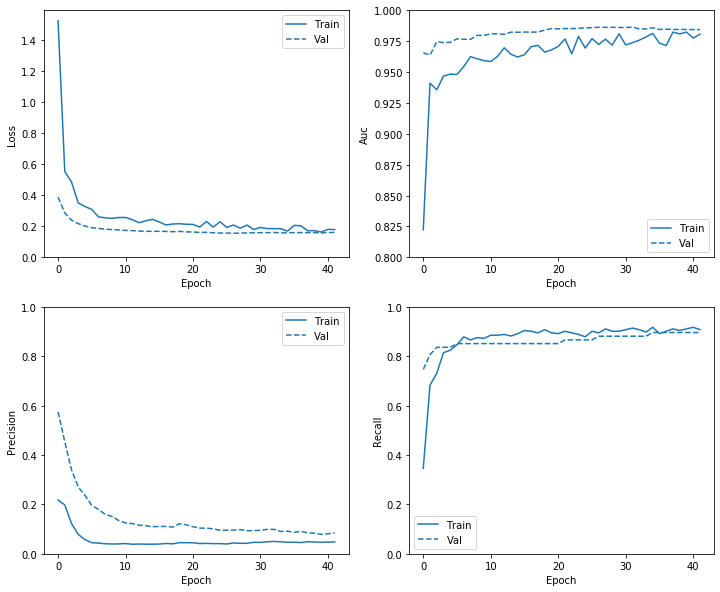

In [71]:
plot_metrics(weighted_history)

## Evaluate Metrics

In [72]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.06250506069850337
tp :  102.0
fp :  740.0
tn :  56109.0
fn :  11.0
accuracy :  0.98681575
precision :  0.121140145
recall :  0.9026549
auc :  0.98156327

Legitimate Transactions Detected (True Negatives): 56109
Legitimate Transactions Incorrectly Detected (False Positives): 740
Fraudulent Transactions Missed (False Negatives): 11
Fraudulent Transactions Detected (True Positives): 102
Total Fraudulent Transactions: 113


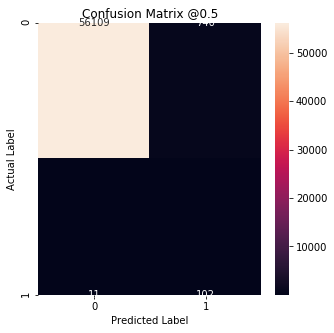

In [73]:
weighted_results = weighted_model.evaluate(
    test_features,
    test_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_weighted)

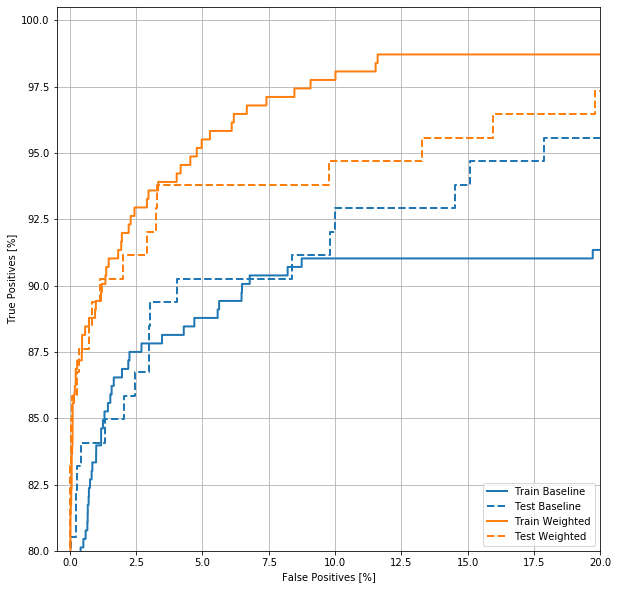

In [74]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle="--")

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="--")

plt.legend(loc='lower right')